## NLP Basics

### Loading the dataset
In this notebook we are working on an emotion classification task. The dataset contains tweets labeled into 6 categories.

First, let's load the libraries and a few utility functions that we will use to help load our data.

In [ ]:
## import torch 
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn

## import other important libraries and functions
import pickle

## function to convert file to pickle format
def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))

## funtion to load pickle file
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

print(torch.__version__)

1.4.0


Download the data:

In [ ]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2020-04-14 12:54:27--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2020-04-14 12:54:28--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc63dfb651602b81941c473a950d.dl.dropboxusercontent.com/cd/0/inline/A13XlDQTwN9D4eeqYmU9uaZGazRXGj0KZDCI-bjef5k8JA-shd81CSea7WSxTVuGJ1TQEpmWh-43k3zAyP4Bl_u4K35z3MHnuu13K2TGOWv-RM_ES_RwIFGRPPOT6ut_sgk/file# [following]
--2020-04-14 12:54:28--  https://uc63dfb651602b81941c473a950d.dl.dropboxusercontent.com/cd/0/inline/A13XlDQTwN9D4eeqYmU9uaZGazRXGj0KZDCI-bjef5k8JA-shd81CSea7WSxTVuGJ1TQEpmWh-43k3zAyP4Bl_u4K3

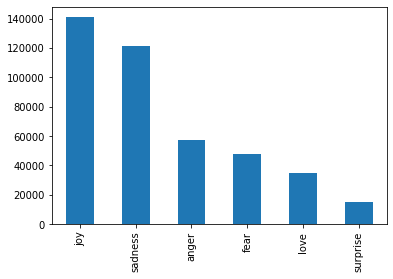

In [ ]:
## load the data
## note we are using the utility function we defined above

data = load_from_pickle(directory="merged_training.pkl")
data.emotions.value_counts().plot.bar()

After a quick glance at the data you will see that it is already preprocessed. Preprocessing is based on my papers which you can find [here](https://www.aclweb.org/anthology/D18-1404/). If you used this data for research purposes, please considering citing the paper:

```json
@inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing"
    year = "2018",
    address = "Brussels, Belgium",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D18-1404",
    doi = "10.18653/v1/D18-1404",
    pages = "3687--3697"
}
```

In [ ]:
len(data)

416809

In [ ]:
## preview the first 10 docs
data.head(10)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


## Tokenizing and Sampling
In the next steps we are going to **tokenize** our pieces of text, create index mapping for words, and also construct a vocabulary.

In [ ]:
## retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

## sampling; we don't need to use the entire data as we only want to show you
## the tokenization/batch preparation process
data = data.sample(n=50000);

print(data.head(10))

                                                     text emotions  token_size
34736   i start to lose that sense of independence in ...     fear          19
26622   i feel as if they are talking bad about me beh...  sadness          13
38867                i feel honoured to be your companion      joy           7
21834   i didnt feel pressure to be perfect and i didn...      joy          18
32713   im feeling quite nostalgic today as if the onl...     love          44
103307  i was positively giddy when the kids left this...  sadness          26
36268                        i feel fine and no labor yet      joy           7
57010   ive fallen into the fickle feeling trap that i...    anger          21
71172   i have let go of those silly qualities and hav...  sadness          30
47812   i feel numb to the anguish that is being repea...  sadness          17


### Building Vocabulary
After tokenizing text, it's time to build the vocabulary, which is used to determine the features that we will be using to train the models.

The code below takes create of creating the vocabulary. The code you see below is standard code you will see in many tutorials. Take some time to understand the intuition behind it.


In [ ]:
## This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
## (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [ ]:
## construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

## examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aa',
 'aaa',
 'aaaa',
 'aaand',
 'aaawesome',
 'aactually',
 'aaron',
 'aaryn',
 'ab']

In [ ]:
## obtain id of token
inputs.word2idx['a']

1

In [ ]:
## you can do the reverse now -- obtain the token via the id
inputs.idx2word[1]

'a'

### Converting Data Into Tensors
Now that we have created our vocab, we can now try to convert the text input into a tensor format, which inolves a vectorization processing using those vocab ids defined above.

Let's try:

In [ ]:
## vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [ ]:
## examples of what is in the input tensors
input_tensor[0:2]

[[11658,
  22968,
  24644,
  14242,
  24282,
  21334,
  16663,
  12059,
  11951,
  24282,
  11658,
  8746,
  1,
  14252,
  15583,
  11106,
  24644,
  6896,
  24370],
 [11658,
  8746,
  1308,
  11725,
  24352,
  1198,
  23938,
  1749,
  61,
  14877,
  2145,
  15861,
  1718]]

---
### EXCERCISE - Obtaining Tensor Representation

Convert the following sentences into their corresponding tensor representations. 

In addition, try to combine/merge the representations into one tensor.

---

In [ ]:
sent1 = "Hello! how is everthing doing?"
sent2 = "I am doing okay"

### YOUR CODE HERE

### YOUR CODE HERE

### Padding Data
In order to train our recurrent neural network (RNN) model for text classification (prsented in the next notebook), we require some type of padding to generate inputs of same length. RNNs expect inputs of same lenght.

In [ ]:
## function to find max lenght of batch
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
## calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [ ]:
## padding sequences

import numpy as np

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [ ]:
## inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

---
### EXERCISE

Pad the tensor you created in the previous exercise for `sent1` and `sent2`.


---

In [ ]:
## check padded sequences for first two examples
input_tensor[0:2]

[array([11658, 22968, 24644, 14242, 24282, 21334, 16663, 12059, 11951,
        24282, 11658,  8746,     1, 14252, 15583, 11106, 24644,  6896,
        24370,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([11658,  8746,  1308, 11725, 24352,  1198, 23938,  1749,    61,
        14877,  2145, 15861,  1718,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

### Binarization
We would like to binarize our `target` values in our dataset so that we can obtain `one-hot encodings` for the target values. 

In [ ]:
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

## convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

## binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [ ]:
## print the one-hot encodings for the first two examples in the dataset
target_tensor[0:2] 

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

In [ ]:
## we can easily check the original values for the first two piece of text
data[0:2]

,text,emotions,token_size
34736,i start to lose that sense of independence in ...,fear,19
26622,i feel as if they are talking bad about me beh...,sadness,13


In [ ]:
## we can easily find the emotion index for instance of the first example above: fear
get_emotion = lambda t: np.argmax(t)
get_emotion(target_tensor[0])

1

In [ ]:
## pass that index to a key/value object to obtain the original emotion 
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}
emotion_dict[get_emotion(target_tensor[0])]

'fear'

### Split Data

We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

Let's do that below. We are going to use the built in `train_test_split` dataset from scikit learn. Let's do that below:

In [ ]:
## Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

## Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

## Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

### Dataset and Data Loader

We can also load the data into a PyTorch `DataLoader` object, which makes it easy to manipulate the data, create batches, and apply further transformations. This simplified our training procedure as well -- we will look a this in the next notebook.

In [ ]:
## Define a few useful parameters

TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

In [ ]:
from torch.utils.data import Dataset, DataLoader

We use the `Dataset` class to represent a dataset object. You override a few methods and you should be able to create the dataset object you need.

In [ ]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

Load the data and then pass it to an `iterator` called `DataLoadder` which finally defines how samples/batches should be prepared.

In [ ]:
## Dataset instance
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)


## Data Loader instance
train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [ ]:
val_dataset.batch_size

64

In [ ]:
## preview of the data
val_dataset.dataset.data[0:2]

[array([11799,  8753, 22354, 18123, 26880, 15861,  7518,   873,  1308,
        11658, 10113, 24644, 22103, 16768, 25140, 16266, 11658, 13397,
        24282, 26633, 11658, 11371, 16768, 24292, 20947, 16768, 26538,
        15597, 11799, 10143, 24644, 21234,  1448, 13741,     1, 13289,
        14249,  9284, 24292, 26543,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([11658,  8746, 13956, 11658, 10867, 13098, 26924, 25764,  9558,
            1,  7140,   873,   745,  1509, 24644, 19908, 24292,  6341,
        16663, 12690,  8199,  1308, 12690, 10737,  8707, 24282, 22202,
         6341,  1198,  9934, 14251,   873, 24561, 12647,  9934, 16353,
        21380,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    